In [20]:
import numpy as np
from xgboost import XGBClassifier
from pandas import read_csv, DataFrame, Series, concat
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from joblib import dump, load
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer 
from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot
from scipy.sparse.csr import csr_matrix
from scipy.sparse import hstack

In [3]:
PRED_FILENAME = 'linear_test.txt'
TRAIN_FILENAME = 'linear_train.txt'
RANDOM_STATE = 41

In [4]:
def extract_substrings(x,sub_len=2):
    res = set()
    for w in x:
        for i in range(len(w)-sub_len):
            if all([let.isalpha() for let in w[i:i+sub_len]]):
                res.add(w[i:i+sub_len])
    return res

In [5]:
def where_ind(x,pred):
    ind = np.full(len(x),0)
    for i,e in enumerate(x):
        if pred(e):
            ind[i] = 1
    return ind.astype(bool)

In [6]:
def custom_stem(word):
    endings = ['а']
    
    word = word.lower()
    for ending in endings:
        if word.endswith(ending):
            word = word[:-len(ending)]
            break
    return word

In [16]:
def show_history(model,metrics):
    results = model.evals_result()
    epochs = len(results['validation_0'][metrics[0]])
    x_axis = range(0, epochs)
    # plot log loss
    for metric in metrics:
        fig, ax = pyplot.subplots()
        ax.plot(x_axis, results['validation_0'][metric], label='Train')
        ax.plot(x_axis, results['validation_1'][metric], label='Test')
        ax.legend()
        pyplot.ylabel(metric)
        pyplot.title(metric)
        pyplot.show()

# Loading and first processing of data

In [7]:
data = read_csv(TRAIN_FILENAME,header=None,names=['str','is_ser'])
data = data.dropna()
x = DataFrame(data.iloc[:,0])
y = data.iloc[:,1]

is_titled = x.iloc[:,0].map(str.istitle)
# steaming
x.iloc[:,0] = x.iloc[:,0].map(custom_stem)

#drop dublicates
x['is_titled'] = is_titled
x = x.drop_duplicates()
is_titled = np.array(x.iloc[:,1])
x = x.iloc[:,0]
y = y[x.index]

is_alpha = where_ind(x,lambda w: all([i.isalpha() for i in w]))
lens = x.map(len)

lens = lens[is_alpha]
x = x[is_alpha]
y = y[is_alpha]
is_titled = is_titled[is_alpha]

add_f = np.stack((is_titled,lens),axis=1)
train_x, val_x, train_y, val_y,train_add_f,val_add_f = train_test_split(x,y,add_f,test_size=0.1)

# Feature creation

In [38]:
vect = TfidfVectorizer(analyzer='char_wb',ngram_range=(1,4),strip_accents='unicode',min_df=0.001)
vect.fit_transform(train_x)
p_train_x = vect.transform(train_x)
p_val_x = vect.transform(val_x)
print(type(p_train_x))
print(f'count features: {p_train_x.shape[1]}')

<class 'scipy.sparse.csr.csr_matrix'>
count features: 566


In [39]:
# concat features
p_train_x = hstack((
    p_train_x,
    csr_matrix(train_add_f.astype(float))))

p_val_x = hstack((
    p_val_x,
    csr_matrix(val_add_f.astype(float))))
p_train_x.shape

(84204, 568)

In [40]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
rp_train_x, rtrain_y = ros.fit_resample(p_train_x, train_y)

In [34]:
metrics = ['logloss','map']

model = XGBClassifier(
    random_state=RANDOM_STATE,
    max_depth=20,
    n_estimators=100,
    verbosity=2,
    booster='gbtree',
    n_jobs=4,
    gamma=0.2,
    subsample=1,
    min_child_weight= 20,
    learning_rate=0.01,
    seed=RANDOM_STATE)
model.fit(rp_train_x,rtrain_y,eval_set=[(rp_train_x,rtrain_y),(p_val_x, val_y)],eval_metric=metrics)
pr = model.predict(p_val_x)
print(f'roc-auc train score: {roc_auc_score(train_y,model.predict_proba(p_train_x)[:,1])}')
print(f'roc-auc score: {roc_auc_score(val_y,model.predict_proba(p_val_x)[:,1])}')
print(f'precision: {precision_score(val_y,pr)}')
print(f'recall: {recall_score(val_y,pr)}')
print(f'f1 score: {f1_score(val_y,pr)}')
dump(model,'model.joblib')

[16:31:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 6 pruned nodes, max_depth=20
[0]	validation_0-logloss:0.687509	validation_0-map:0.894454	validation_1-logloss:0.687697	validation_1-map:0.42163
[16:31:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 844 extra nodes, 0 pruned nodes, max_depth=20
[1]	validation_0-logloss:0.682006	validation_0-map:0.89471	validation_1-logloss:0.682399	validation_1-map:0.425408
[16:31:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 4 pruned nodes, max_depth=20
[2]	validation_0-logloss:0.676586	validation_0-map:0.892557	validation_1-logloss:0.677183	validation_1-map:0.431744
[16:31:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 6 pruned no

[16:32:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 6 pruned nodes, max_depth=20
[29]	validation_0-logloss:0.56014	validation_0-map:0.923888	validation_1-logloss:0.567923	validation_1-map:0.501194
[16:32:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 4 pruned nodes, max_depth=20
[30]	validation_0-logloss:0.556682	validation_0-map:0.925119	validation_1-logloss:0.564721	validation_1-map:0.507565
[16:32:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 6 pruned nodes, max_depth=20
[31]	validation_0-logloss:0.553255	validation_0-map:0.925813	validation_1-logloss:0.561636	validation_1-map:0.50626
[16:32:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 960 extra nodes, 4 pruned

[16:32:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 8 pruned nodes, max_depth=20
[58]	validation_0-logloss:0.477028	validation_0-map:0.937037	validation_1-logloss:0.493123	validation_1-map:0.532645
[16:32:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 858 extra nodes, 2 pruned nodes, max_depth=20
[59]	validation_0-logloss:0.474736	validation_0-map:0.937237	validation_1-logloss:0.491104	validation_1-map:0.533122
[16:32:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 4 pruned nodes, max_depth=20
[60]	validation_0-logloss:0.472416	validation_0-map:0.9377	validation_1-logloss:0.489067	validation_1-map:0.535616
[16:32:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 890 extra nodes, 12 prun

[16:32:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 4 pruned nodes, max_depth=20
[87]	validation_0-logloss:0.419501	validation_0-map:0.945306	validation_1-logloss:0.443388	validation_1-map:0.555344
[16:32:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 952 extra nodes, 8 pruned nodes, max_depth=20
[88]	validation_0-logloss:0.417811	validation_0-map:0.945544	validation_1-logloss:0.441945	validation_1-map:0.556541
[16:32:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 2 pruned nodes, max_depth=20
[89]	validation_0-logloss:0.416124	validation_0-map:0.945755	validation_1-logloss:0.440536	validation_1-map:0.556882
[16:32:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 952 extra nodes, 4 prun

['model.joblib']

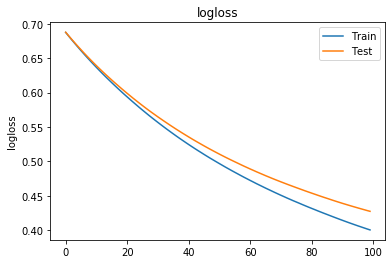

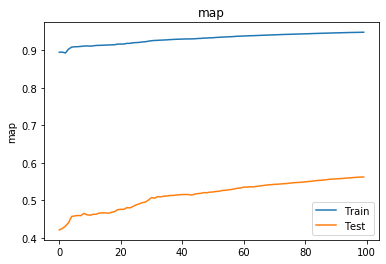

In [35]:
show_history(model,metrics)

In [41]:
test = read_csv(PRED_FILENAME,header=None)
res = test.iloc[:,0]

is_titled = res.map(str.istitle).astype(float)
res = res.map(custom_stem)
lens = res.map(len)

a_f = np.stack((is_titled,lens),axis=1)
p_res = vect.transform(res)
p_res = csr_matrix(np.concatenate((p_res.toarray(),a_f),axis=1))

test_prediction = model.predict_proba(p_res)[:,1]
if len(test_prediction) == 188920:
    DataFrame(test_prediction.astype(float),columns=['Answer']).to_csv(r'res9.txt',index_label='Id')
else:
    print('err')

In [36]:
#feature selection
usful_features = model.feature_importances_[:-2] != 0
ind_f_map = {v: k for k, v in vect.vocabulary_.items()}
u_f = []
for i,cond in enumerate(usful_features):
    if cond:
        u_f.append(ind_f_map[i])
        
dump(u_f,'selected_features.joblib')

#feature reporcessing
vect = TfidfVectorizer(analyzer='char_wb',ngram_range=(2,2),strip_accents='unicode',vocabulary=u_f)
vect.fit_transform(train_x)
p_train_x = vect.transform(train_x)
p_val_x = vect.transform(val_x)
print(type(p_train_x))
print(f'count features: {p_train_x.shape[1]}')

<class 'scipy.sparse.csr.csr_matrix'>
count features: 271
